# Analysing Meeting Graphs for Topics

In [1]:
import os, sys
sys.path.insert(0, '../src')

In [2]:
%load_ext autoreload
%autoreload 2

In [20]:
from graphrank.graphrank import GraphRank
from graphrank.utils import GraphUtils, TextPreprocess
from graphrank import dgraph as dg
import networkx as nx
import json as js
import keyphrase_extraction as kp
import community
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shashank/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Initialize Class objects

In [21]:
gutils = GraphUtils()
tp = TextPreprocess()
gr = GraphRank()

### Utility functions

In [22]:
def sort_by_value(item_list, order='desc'):
    """
    A utility function to sort lists by their value.
    Args:
        item_list:
        order:

    Returns:

    """

    if order == 'desc':
        sorted_list = sorted(item_list, key=lambda x: (x[1], x[0]), reverse=True)
    else:
        sorted_list = sorted(item_list, key=lambda x: (x[1], x[0]), reverse=False)

    return sorted_list

In [23]:
def read_json(json_file):
    with open(json_file) as f:
        document = js.load(f)
    return document

### Plotting functions

In [24]:
plt.rcParams['figure.figsize']= [16, 8]
def draw_graph(graph):
    pos = nx.spring_layout(graph, k=0.2, iterations=20)
    nx.draw_networkx(graph, pos=pos, arrows=False, with_labels=True, node_size=40, alpha=0.65, width=0.2,
                     edge_color='b', font_size=11)
    plt.title("Meeting graph", fontsize=22, fontname='Arial')
    plt.axis('off')
    plt.show()

In [25]:
plt.rcParams['figure.figsize']= [16, 8]
def draw_property_graph(G, node_values, node_list, measure_name):
    pos = nx.spring_layout(G, k=0.2, iterations=20)
    nodes=nx.draw_networkx_nodes(G, pos, node_size=100, cmap=plt.cm.viridis,node_color=node_values,nodelist=node_list, alpha=0.85)
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    edges=nx.draw_networkx_edges(G, pos, edge_color='r', alpha=0.1)
    plt.title(measure_name, fontsize=22, fontname='Arial')
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

## Meeting Graphs

### Read Meeting transcript

In [26]:
meeting_doc = read_json("../data/sample_req.json")

In [27]:
segment_df = kp.reformat_input(meeting_doc)

In [28]:
segment_df.head(5)

,confidence,createdAt,deleted,deletedAt,duration,endTime,filteredText,id,languageCode,originalText,recordingId,spokenBy,startTime,status,tenantId,transcriber,transcriptId,updatedAt
1,0.489480,2019-01-29 05:22:06:231474,False,None,10,2019-01-29 05:22:05:000000,Hello yeah hi.,439f72efc988422fb0c35e3c1316b150,en-US,Hello yeah hi.,e43db149c0b44bf8b71433efe8393a02,394d6dd0-7dbe-4d77-92c6-2af7f8314329,2019-01-29 05:21:55:000000,completed,932daeaf-6ae7-44ed-8d8d-f0b6feedc3aa,deepgram,e62bba58-b959-4aab-af7e-a75737fd736c,2019-01-29 05:22:11:881388
3,0.873764,2019-01-29 05:22:26:859489,False,None,5,2019-01-29 05:22:26:000000,We can me I think in.,4c491448e1eb495abeac36e708622034,en-US,We can me I think in.,0675adae0360423e9fe65bdcdaa948da,7eeb4d50-dba0-4cf8-a393-0d93a5ad2c69,2019-01-29 05:22:21:000000,completed,932daeaf-6ae7-44ed-8d8d-f0b6feedc3aa,deepgram,e62bba58-b959-4aab-af7e-a75737fd736c,2019-01-29 05:22:28:390325
4,0.836269,2019-01-29 05:22:41:742230,False,None,15,2019-01-29 05:22:41:000000,We can need just showcase on the ******** what...,e42e7760d9e0468989f6c4c3af161adc,en-US,We can need just showcase on the document what...,384d4fa3850f43aebb46575b3c2a5a96,394d6dd0-7dbe-4d77-92c6-2af7f8314329,2019-01-29 05:22:26:000000,completed,932daeaf-6ae7-44ed-8d8d-f0b6feedc3aa,deepgram,e62bba58-b959-4aab-af7e-a75737fd736c,2019-01-29 05:22:44:459082
5,0.000000,2019-01-29 05:22:51:551845,False,None,5,2019-01-29 05:22:51:000000,,25d67d06a3ee454fa38fb9c641887e69,en-US,,a922d5c5b55b495d8cf2bf5b9ccebbd2,394d6dd0-7dbe-4d77-92c6-2af7f8314329,2019-01-29 05:22:46:000000,no_transcription,932daeaf-6ae7-44ed-8d8d-f0b6feedc3aa,deepgram,e62bba58-b959-4aab-af7e-a75737fd736c,2019-01-29 05:22:53:063522
6,0.901842,2019-01-29 05:22:54:863524,False,None,3,2019-01-29 05:22:54:000000,Yeah yeah yeah yeah.,130d727e79e6475f9ee3e2a0b50ec415,en-US,Yeah yeah yeah yeah.,b3280d9fd6af4d13a91cc3dc38829254,7eeb4d50-dba0-4cf8-a393-0d93a5ad2c69,2019-01-29 05:22:51:000000,completed,932daeaf-6ae7-44ed-8d8d-f0b6feedc3aa,deepgram,e62bba58-b959-4aab-af7e-a75737fd736c,2019-01-29 05:22:56:181926


In [29]:
text_list = kp.read_segments(segment_df=segment_df)

### Build Meeting Graph

In [30]:
meeting_graph = kp.build_custom_graph(text_list)

Could not process the sentence: ErrorMsg: 'NoneType' object is not iterable
Could not process the sentence: ErrorMsg: 'NoneType' object is not iterable
Could not process the sentence: ErrorMsg: 'NoneType' object is not iterable
Could not process the sentence: ErrorMsg: 'NoneType' object is not iterable
Could not process the sentence: ErrorMsg: 'NoneType' object is not iterable
Could not process the sentence: ErrorMsg: 'NoneType' object is not iterable
Could not process the sentence: ErrorMsg: 'NoneType' object is not iterable
Could not process the sentence: ErrorMsg: 'NoneType' object is not iterable
Could not process the sentence: ErrorMsg: 'NoneType' object is not iterable
Could not process the sentence: ErrorMsg: 'NoneType' object is not iterable
Could not process the sentence: ErrorMsg: 'NoneType' object is not iterable
Could not process the sentence: ErrorMsg: 'NoneType' object is not iterable
Could not process the sentence: ErrorMsg: 'NoneType' object is not iterable
Could not pr

In [31]:
meeting_graph.number_of_nodes(), meeting_graph.number_of_edges()

(366, 1162)

### Visualize Graph

/Users/shashank/anaconda3/envs/textrank/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


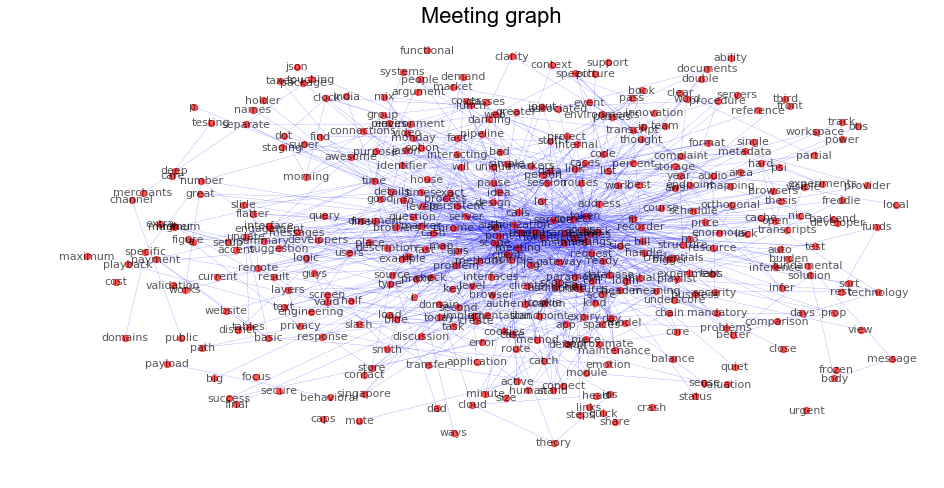

In [32]:
draw_graph(meeting_graph)

## Analysing Graph properties

### Betweenness property

In [33]:
between_scores = nx.betweenness_centrality(meeting_graph)

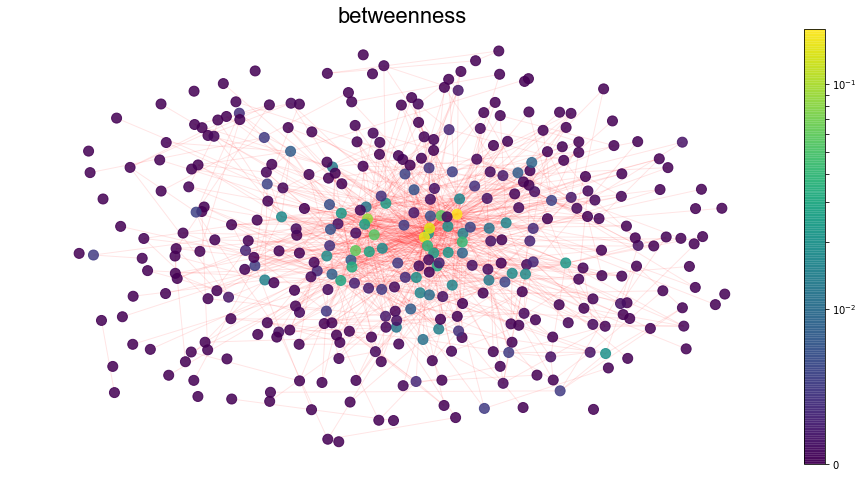

In [34]:
draw_property_graph(meeting_graph, list(between_scores.values()), list(between_scores.keys()), 'betweenness')

### Degree Centrality

In [35]:
deg_central = nx.degree_centrality(meeting_graph)

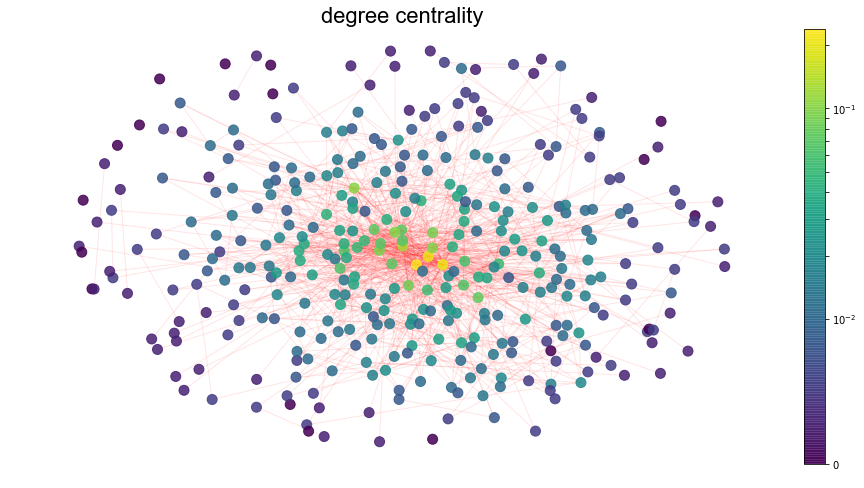

In [36]:
draw_property_graph(meeting_graph, list(deg_central.values()), list(deg_central.keys()), 'degree centrality')

### Closeness centrality

In [37]:
closeness_central = nx.closeness_centrality(meeting_graph)

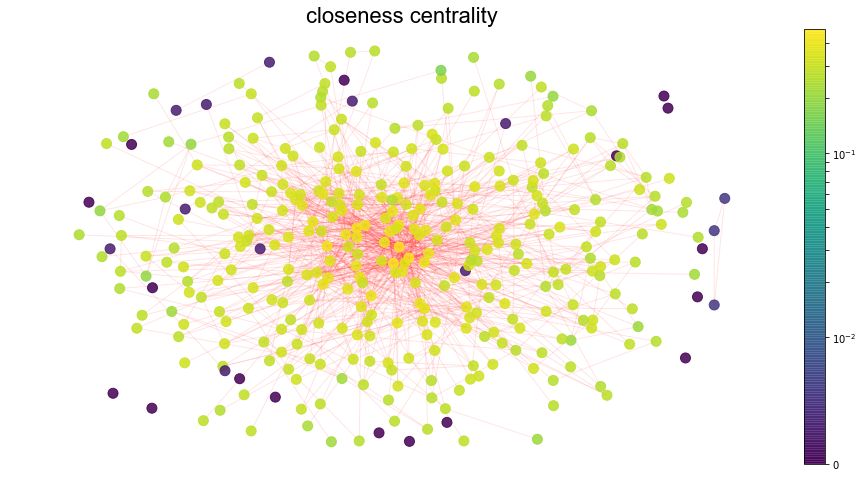

In [38]:
draw_property_graph(meeting_graph, list(closeness_central.values()), list(closeness_central.keys()), 'closeness centrality')

## Graph Partitioning for Topics - Louvain Algorithm

In [46]:
# Starting with an initial partition of the graph and running the Louvain algorithm for Community Detection
partition=community.best_partition(meeting_graph)
print('Completed Louvain algorithm .. . . ' )
values=[partition.get(node) for node in meeting_graph.nodes()]
list_com=partition.values()

# Creating a dictionary like {community_number:list_of_participants}
topic_nodes={}

# Populating the dictionary with items
for each_item in partition.items():
    community_num=each_item[1]
    community_node=each_item[0]
    if community_num in topic_nodes:
        value=topic_nodes.get(community_num) + ' | ' + str(community_node)
        topic_nodes.update({community_num:value})
    else:
        topic_nodes.update({community_num:community_node})

# # Creating a dataframe from the diet, and getting the output into excel
# community_df=pd.DataFrame.from_dict(dict_nodes, orient='index',columns=['Members'])
# community_df.index.rename('Community_Num' , inplace=True)

Completed Louvain algorithm .. . . 


### Subgraphs or Communities formed from the Meeting graph -- Possible Topics

In [47]:
topic_nodes

{0: 'document | ether | marker | example | developers | api | apis | uc | summary | sort | rate | points | simple | json | demand | remote | create | slash | flatter | guys | holder | steps | gateway | aws | schedule | bigger | power | track | third | staging | context | ip | model',
 1: 'update | design | reference | clients | session | storage | local | clear | partial | a. | stand | authentication | header | connect | transfer | screen | payment | tables | basic | emotion | rest | funds',
 2: 'final | second | log | browser | app | credentials | login | user | token | double | size | ready | best | multiple | expiry | maintenance | source | store | slack | endpoint | contact | pass | word | complaint | single | initial | list | idea | bad | users | times | days | browsers | cover | unique | video | associated | documents | inference | interfaces | input | procedure | enormous | infer | care | dad | awesome | passes | clarity | human | lack | orthogonal | psi',
 3: 'point | option | 

### Visualize Community/Subgraph structure

Modularity:  0.4525556121708373
Total number of Communities= 34


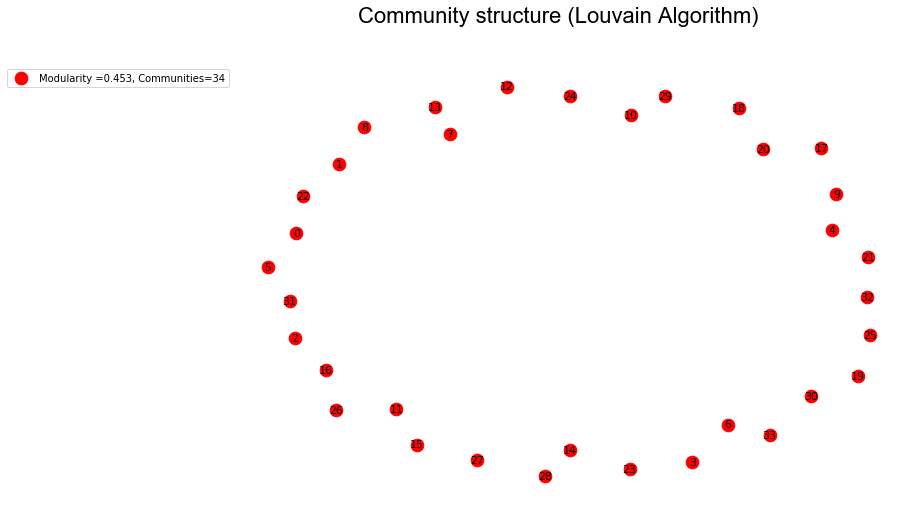

In [48]:
plt.rcParams['figure.figsize']= [12, 8]
G_comm=nx.Graph()

# Populating the data from the node dictionary created earlier
G_comm.add_nodes_from(topic_nodes)

# Calculating modularity and the total number of communities
mod=community.modularity(partition,meeting_graph)
print("Modularity: ", mod)
print("Total number of Communities=", len(G_comm.nodes()))

# Creating the Graph and also calculating Modularity
plt.rcParams['figure.figsize']= [12, 8]
pos_louvain=nx.spring_layout(G_comm)
nx.draw_networkx(G_comm, pos_louvain, with_labels=True,node_size=160,font_size=11,label='Modularity =' + str(round(mod,3)) +
                    ', Communities=' + str(len(G_comm.nodes())))
plt.suptitle('Community structure (Louvain Algorithm)',fontsize=22,fontname='Arial')
plt.box(on=None)
plt.axis('off')
plt.legend(bbox_to_anchor=(0,1), loc='best', ncol=1)

### Visualize Subgraphs

/Users/shashank/anaconda3/envs/textrank/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


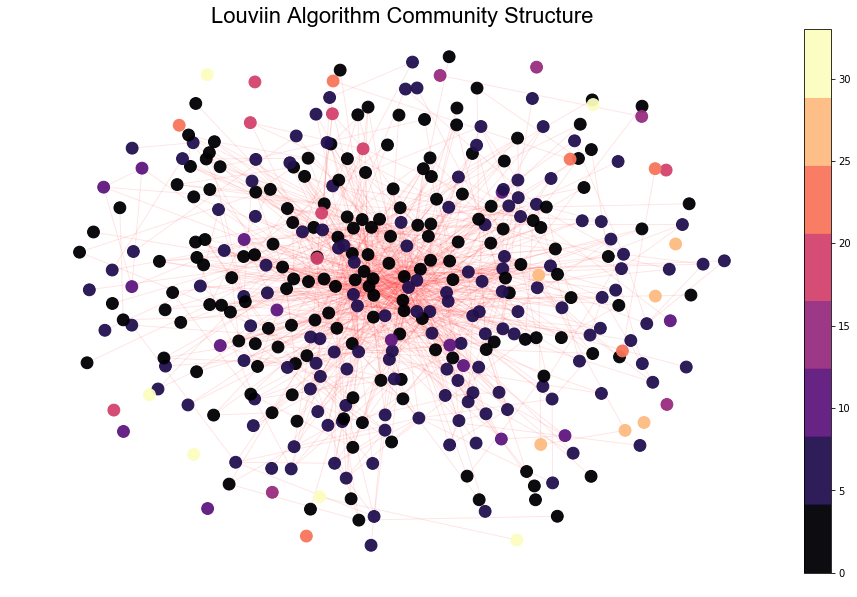

In [49]:
plt.rcParams['figure.figsize']= [16, 10]
measure_name = "Louviin Algorithm Community Structure"
pos = nx.spring_layout(meeting_graph, k=0.2, iterations=20)
nodes_plot=nx.draw_networkx_nodes(meeting_graph, pos, node_size=140, cmap=plt.get_cmap('magma', len(G_comm.nodes())/4),node_color=values, alpha=0.95)
edges_plot=nx.draw_networkx_edges(meeting_graph, pos, edge_color='r', alpha=0.1)
plt.title(measure_name, fontsize=22, fontname='Arial')
plt.colorbar(nodes_plot)
plt.axis('off')
plt.show()

## Graph Partitioning using Girvan-Newman

In [ ]:
comp = nx.algorithms.community.girvan_newman(meeting_graph)

In [ ]:
# Creating a dictionary for the community number assocaited with each node
com=0
thisdict={}

# Populating the items of the dictionary
for c in next(comp):
    list=sorted(c)
    for i in range(len(list)):
        if list[i] in thisdict:
            print('already found')
        else:
            thisdict.update({list[i]: com})
        i+=1
    com+=1

In [ ]:
# Creating a dictionary like 'Community num':'List of participants'
dict_nodes_girvan={}
for each_item in thisdict.items():
    community_num=each_item[1]
    community_node=each_item[0]
    
    if community_num in dict_nodes_girvan:
        value=dict_nodes_girvan.get(community_num) + ' | ' + str(community_node)
        dict_nodes_girvan.update({community_num: value})
    else:
        dict_nodes_girvan.update({community_num: community_node})
        
# Creating the output file
# community_df_girvan=pd.DataFrame.from_dict(dict_nodes_girvan, orient='index',columns=['Members'])
# community_df_girvan.index.rename('Community Num', inplace=True)
# community_df_girvan.to_csv('Community_List_girvan_snippet.csv')

# Creating a graph where each node represents a community
G_comm_girvan=nx.Graph()
G_comm_girvan.add_nodes_from(dict_nodes_girvan)

# Calculation of number of communities and modularity
print("Total number of Communities=", len(G_comm_girvan.nodes()))
mod_girv=community.modularity(thisdict,meeting_graph)
print("Modularity:", mod_girv)

# Creation of the graph
pos_girvan=nx.spring_layout(G_comm_girvan)
nx.draw_networkx(G_comm_girvan, pos_girvan,with_labels=True,node_size=160,font_size=11, node_color='yellow',
                 label='Modularity =' + str(round(mod_girv,3)) +', Communities=' + str(len(G_comm_girvan.nodes())))
plt.suptitle('Community Structure (Girvan-Newman Algorithm)',fontsize=22,fontname='Arial')
plt.box(on=None)
plt.axis('off')
plt.legend(bbox_to_anchor=(0,1), loc='best', ncol=1)
# plt.savefig('Girvan-Newman.png', dpi=400, bbox_inches='tight')

### Subgraphs from Girvan-Newman

In [ ]:
dict_nodes_girvan

### Visualize Subgraphs

In [ ]:
values_girvan=[thisdict.get(node) for node in meeting_graph.nodes()]

In [ ]:
# Now we try to obtain the color coded graph for each community
plt.rcParams['figure.figsize']= [16, 10]
measure_name = "Girvan-Newman Algorithm Community Structure"
pos = nx.spring_layout(meeting_graph, k=0.2, iterations=20)
nodes_plot=nx.draw_networkx_nodes(meeting_graph, pos, node_size=140, cmap=plt.get_cmap('magma', len(G_comm_girvan.nodes())/4),node_color=values_girvan, alpha=0.95)
edges_plot=nx.draw_networkx_edges(meeting_graph, pos, edge_color='r', alpha=0.1)
plt.title(measure_name, fontsize=22, fontname='Arial')
plt.colorbar(nodes_plot)
plt.axis('off')
plt.show()

# Experiment 1

## Identify possible `hotspots` in the meeting based on clusters formed in the graph

Build a main **KeywordGraph**, with keywords forming the nodes. The nodes will have a property stating all the sentences/sentence ID that they are part of.
1. On a meeting-level graph, compute **Betweenness** and **Clustering Coefficient** scores.
2. **Assumption 1**: Nodes with higher **Betweenness** and/or **Clustering Coefficients** represent the different topics in a meeting.
3. Retrieve the sentences that these subgraphs are a part of and calculate **sentence embedding** using LM
4. **Assumption 2**: These sentences are contextually important (possible representation of Channel minds)
5. Get similarity scores of every node w.r.t to these sentences. 
6. Similarity of edge could be:
    1. Linear combination of node similarities
    2. Similarity of the **keyphrase** (formed by combining adjacent nodes) with reference to the sentences.
7. Re-rank the graph with these edge weights.

In [50]:
def get_graph_attrs(df):
    meeting_graph = nx.Graph()
    for i in range(len(df)):
        attrs = {}
        text = df.iloc[i].get('originalText')
        attrs['originalText'] = df.iloc[i].get('originalText')
        attrs['spokenBy'] = df.iloc[i].get('spokenBy')
        attrs['id'] = df.iloc[i].get('id')
        attrs['createdAt'] = df.iloc[i].get('createdAt')
        attrs['shortId'] = i + 1
        try:
            original_tokens, pos_tuple, filtered_pos_tuple = kp.process_text(text)
        except Exception as e:
            print(e)
        meeting_graph = gr.build_word_graph(input_pos_text=filtered_pos_tuple,
                                                original_tokens=original_tokens,
                                                window=4,
                                                syntactic_filter=['NOUN', 'PROPN', 'ADJ', 'FW'],
                                                preserve_common_words=False,
                                                node_attributes=attrs)
    return meeting_graph

In [ ]:
g.clear()
g = get_graph_attrs(segment_df)

In [ ]:
g.number_of_nodes()

In [ ]:
g.nodes.data()

In [ ]:
example_topic = topic_nodes.get(9)

In [ ]:
example_topic_list = example_topic.split(' | ')

In [ ]:
example_topic_list

In [127]:
def get_topics(topic_nodes, topic_number):
    topic = topic_nodes.get(topic_number)
    topic_list = topic.split(' | ')
    return topic_list

In [135]:
def get_topic_segments(g, example_topic_list):
    topic_segment = []
    topic_text = []
    topic_dict = {}
    for topics in example_topic_list:
        seg_id = g.nodes[topics]['shortId']
        text = g.nodes[topics]['originalText']
        topic_segment.append(seg_id)
        topic_text.append(text)
        topic_dict[seg_id] = text
    #topic_dict = dict(zip(set(topic_segment), set(topic_text)))
    # topic_dict_sorted = sorted(topic_dict.items(), key=lambda x: (x[0], x[1]), reverse=False)
    return topic_dict

In [ ]:
topic_dict = get_topic_segments(g, example_topic_list)

In [ ]:
topic_dict

In [ ]:
topic_0 = get_topics(topic_nodes, 28)

In [ ]:
topic_segments_dict = get_topic_segments(g, topic_0)

In [ ]:
topic_segments_dict

### Testing on HR article

In [53]:
def read_text(text_file):
    with open(text_file, 'r') as f_:
        doc = f_.read()
    return doc

In [54]:
hr_doc = read_text("../data/input_text.txt")

In [55]:
print(hr_doc)

Here's what power looks like in an employer, my friends...
Less than a month after unanimously passing a contentious tax on big business, Seattle’s city council has voted to repeal the so-called “head tax.” Against the fervent protestations of residents and local coalitions—which were extended to a full hour of testimony—council members voted 7-2 to pulled the plug on what would have been a vital source of support for city’s growing homeless population. 
Let me break that down for you: The city council unanimously passed the tax, then one month later repealed it.  What happened?  The city's biggest employer, Amazon, said "what up", flexed it's muscles and reversed the whole thing in a month. Drevil
Before breaking down what Amazon did and being awestruck by the raw power, let's learn more about the "head tax" that was proposed from Gizmodo:
In the form it was passed last month, the “head tax” would shave off $275 per full-time employee at companies generating over $20 million in revenu

In [56]:
hr_doc = hr_doc.splitlines()

In [57]:
hr_doc = [sent.split('.') for sent in hr_doc]

In [58]:
hr_doc_list = [proc_sent for sent in hr_doc for proc_sent in sent]

In [120]:
hr_doc_list

["Here's what power looks like in an employer, my friends",
 '',
 '',
 '',
 'Less than a month after unanimously passing a contentious tax on big business, Seattle’s city council has voted to repeal the so-called “head tax',
 '” Against the fervent protestations of residents and local coalitions—which were extended to a full hour of testimony—council members voted 7-2 to pulled the plug on what would have been a vital source of support for city’s growing homeless population',
 ' ',
 'Let me break that down for you: The city council unanimously passed the tax, then one month later repealed it',
 '  What happened?  The city\'s biggest employer, Amazon, said "what up", flexed it\'s muscles and reversed the whole thing in a month',
 ' Drevil',
 'Before breaking down what Amazon did and being awestruck by the raw power, let\'s learn more about the "head tax" that was proposed from Gizmodo:',
 'In the form it was passed last month, the “head tax” would shave off $275 per full-time employee a

In [90]:
def build_hr_graph(hr_doc_list):
    hr_graph = nx.Graph()
    for i in range(len(hr_doc_list)):
        attrs = {}
        hr_text = hr_doc_list[i]
        attrs['shortId'] = i + 1
        attrs['originalText'] = hr_text
        try:
            original_tokens, pos_tuple, filtered_pos_tuple = kp.process_text(hr_text)
            hr_graph = gr.build_word_graph(input_pos_text=filtered_pos_tuple,
                                                    original_tokens=original_tokens,
                                                    window=4,
                                                    syntactic_filter=['NOUN', 'PROPN', 'ADJ', 'FW'],
                                                    preserve_common_words=False,
                                                    node_attributes=attrs)
        except Exception as e:
            print(e)
    return hr_graph

In [91]:
hr_graph = build_hr_graph(hr_doc_list)

'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable


In [170]:
hr_graph.number_of_nodes()

134

In [171]:
hr_graph.nodes.data()

NodeDataView({'power': {'shortId': 11, 'originalText': 'Before breaking down what Amazon did and being awestruck by the raw power, let\'s learn more about the "head tax" that was proposed from Gizmodo:'}, 'employer': {'shortId': 9, 'originalText': '  What happened?  The city\'s biggest employer, Amazon, said "what up", flexed it\'s muscles and reversed the whole thing in a month'}, 'friends': {'shortId': 1, 'originalText': "Here's what power looks like in an employer, my friends"}, 'month': {'shortId': 12, 'originalText': 'In the form it was passed last month, the “head tax” would shave off $275 per full-time employee at companies generating over $20 million in revenue, totaling an estimated $47 million per year for five years'}, 'contentious': {'shortId': 5, 'originalText': 'Less than a month after unanimously passing a contentious tax on big business, Seattle’s city council has voted to repeal the so-called “head tax'}, 'tax': {'shortId': 28, 'originalText': 'My city, the ATL, is in 

In [204]:
nx.is_connected(meeting_graph)

False

In [202]:
bet = nx.current_flow_closeness_centrality(hr_graph)

NetworkXError: Graph not connected.

In [196]:
bet

{'power': 0.27667960223138494,
 'employer': 0.25476438621305736,
 'friends': 0.22278097842007613,
 'month': 0.2639097744360902,
 'contentious': 0.2486106570774763,
 'tax': 0.33968584828407655,
 'big': 0.25476438621305736,
 'business': 0.2579569223811408,
 'seattles': 0.2579569223811408,
 'city': 0.29747055500021735,
 'council': 0.29576095410941144,
 'socalled': 0.2592564534762599,
 'head': 0.313795158628278,
 'fervent': 0.12123063843353969,
 'protestations': 0.12151689732004153,
 'residents': 0.13349521664082384,
 'local': 0.14003375786404787,
 'coalitionswhich': 0.14003375786404787,
 'full': 0.15571075950087018,
 'hour': 0.16415440515163507,
 'testimonycouncil': 0.16363245155814815,
 'members': 0.18478422267517988,
 'plug': 0.19604726100966705,
 'vital': 0.22472666382112486,
 'source': 0.2404785327805495,
 'support': 0.26123048738597765,
 'citys': 0.2789290298918027,
 'homeless': 0.25476438621305736,
 'population': 0.23077312114366633,
 'biggest': 0.25226669615214503,
 'amazon': 0.323

In [213]:
hr_keyphrases = gr.get_keyphrases(hr_graph, normalize_nodes='closeness')

['campaignvolunteersocial', 'media', 'management', 'mayor', 'jenny', 'durkan']
['clear', 'message']
['expensive', 'political', 'fight']
['quick', 'legislative', 'retreat']
['second', 'headquarters', 'hell']
['seattle', 'head', 'tax']
['socalled', 'head', 'tax']
['head', 'tax']
['cre8tive', 'empowerment']
['seattles', 'city', 'council']
['local', 'coalitionswhich']
['city', 'council', 'chambers']
['contentious', 'tax']
['affordable', 'housing', 'seattle']
['downtown', 'seattle', 'click']
['giant', 'online', 'retailer']
['public', 'disclosure', 'commission']
['full', 'hour']
['city', 'council']
['homeless', 'services']
['seattle', 'cliff', 'notes']
['jobs', 'campaigna', 'coalition']
['public', 'services']
['fervent', 'protestations']
['signature', 'gathering']
['citys', 'biggest', 'employer']
['testimonycouncil', 'members']
['homelessness', 'crisis', 'critics']
['homeless', 'rate']
['homeless', 'population']
['second', 'hq']
['financial', 'support']
['foremost', 'catalysts']
['vital', 's

In [212]:
hr_keyphrases

[('campaignvolunteersocial media management mayor jenny durkan',
  0.7508166399745307),
 ('clear message', 0.6659156339967021),
 ('expensive political fight', 0.612979793188587),
 ('quick legislative retreat', 0.5744281044391375),
 ('second headquarters hell', 0.39634706088172683),
 ('places', 0.33295781699835103),
 ('seattle head tax', 0.2420502176951538),
 ('socalled head tax', 0.19942558792520226),
 ('prolonged', 0.1891186119877502),
 ('head tax', 0.1779010690693076),
 ('months', 0.17079542814229268),
 ('cre8tive empowerment', 0.12569226081330498),
 ('seattles city council', 0.1250457998738614),
 ('local coalitionswhich', 0.12468413214166477),
 ('city council chambers', 0.12447602941151661),
 ('contentious tax', 0.12440690962685591),
 ('affordable housing seattle', 0.12419203846658558),
 ('downtown seattle click', 0.11574689833196444),
 ('giant online retailer', 0.107958182013805),
 ('public disclosure commission', 0.10728426693347226),
 ('full hour', 0.10587969439387825),
 ('tax', 

In [180]:
hr_keyphrases = gr.post_process(hr_keyphrases)

In [181]:
hr_keyphrases

[('campaignvolunteersocial media management mayor jenny durkan',
  145.7209672491883),
 ('fervent protestations', 116.11819182599594),
 ('contentious tax', 86.76390568646926),
 ('socalled head tax', 75.49004509061346),
 ('expensive political fight', 49.15012782898455),
 ('giant online retailer', 47.442548749823146),
 ('seattles city council', 46.6543882465859),
 ('downtown seattle click', 46.25606251139244),
 ('big business', 36.993640601107444),
 ('quick legislative retreat', 34.79432380703417),
 ('affordable housing seattle', 15.583324753015981),
 ('clear message', 15.020653398421851),
 ('jobs campaigna coalition', 13.007897150615634),
 ('large businesses', 12.683539962115999),
 ('second headquarters hell', 12.059172040419849),
 ('raw power', 10.293580978574857),
 ('homelessness crisis critics', 10.030863955728051),
 ('freak outs', 8.8835451231365),
 ('seattle cliff notes', 7.8495931935470145),
 ('office towers', 7.769326909469537),
 ('november speakers', 7.241763543084176),
 ('backr

In [108]:
def louvain_partition(graph):
    # Starting with an initial partition of the graph and running the Louvain algorithm for Community Detection
    partition=community.best_partition(graph)
    print('Completed Louvain algorithm .. . . ' )
    values=[partition.get(node) for node in graph.nodes()]
    list_com=partition.values()

    # Creating a dictionary like {community_number:list_of_participants}
    topic_nodes={}

    # Populating the dictionary with items
    for each_item in partition.items():
        community_num=each_item[1]
        community_node=each_item[0]
        if community_num in topic_nodes:
            value=topic_nodes.get(community_num) + ' | ' + str(community_node)
            topic_nodes.update({community_num:value})
        else:
            topic_nodes.update({community_num:community_node})
    return topic_nodes, partition

In [129]:
hr_topic_nodes, hr_partition = louvain_partition(hr_graph)

Completed Louvain algorithm .. . . 


In [152]:
len(hr_topic_nodes)

9

In [137]:
hr_topic_list = get_topics(hr_topic_nodes, 0)

In [138]:
hr_topic_list

['power',
 'employer',
 'friends',
 'head',
 'support',
 'citys',
 'population',
 'biggest',
 'amazon',
 'muscles',
 'awestruck',
 'raw',
 'gizmodo',
 'form',
 'repeal',
 'starbucks',
 'financial',
 'signatures',
 'referendum',
 'november',
 'critics',
 'backroom',
 'deal',
 'cliff',
 'notes',
 'careful',
 'town']

In [139]:
hr_topic_segments = get_topic_segments(hr_graph, hr_topic_list)

In [140]:
hr_topic_segments

{11: 'Before breaking down what Amazon did and being awestruck by the raw power, let\'s learn more about the "head tax" that was proposed from Gizmodo:',
 9: '  What happened?  The city\'s biggest employer, Amazon, said "what up", flexed it\'s muscles and reversed the whole thing in a month',
 1: "Here's what power looks like in an employer, my friends",
 28: 'My city, the ATL, is in the running for the second HQ, and the Seattle head tax teaches us one thing pretty clearly - Be careful what you ask for when Amazon comes to town',
 16: 'The repeal comes a day after the No Tax on Jobs campaign—a coalition which large businesses which would be affected by the “head tax,” like Amazon and Starbucks, pledged significant financial support to—announced it had gotten over 45,000 signatures, more than enough to generate a referendum to overturn the tax in November',
 6: '” Against the fervent protestations of residents and local coalitions—which were extended to a full hour of testimony—council

In [145]:
hr_topic_list_2 = get_topics(hr_topic_nodes, 1)

In [146]:
hr_topic_list_2

['month',
 'contentious',
 'tax',
 'big',
 'business',
 'seattles',
 'city',
 'council',
 'socalled',
 'fulltime',
 'employee',
 'companies',
 'revenue',
 'year',
 'years',
 'public',
 'day',
 'jobs',
 'campaigna',
 'coalition',
 'large',
 'businesses',
 'speakers',
 'behalf',
 'chambers',
 'grassroots',
 'disclosure']

In [147]:
hr_topic_segments_2 = get_topic_segments(hr_graph, hr_topic_list_2)

In [154]:
list(hr_topic_segments_2.keys())

[12, 5, 28, 22, 17, 16]

In [150]:
hr_topic_list_8 = get_topics(hr_topic_nodes, 8)

In [151]:
hr_topic_list_8

['hell', 'places', 'clear', 'message']

In [161]:
hr_topic_top_ids = []
seg_list = []
for i in range(len(hr_topic_nodes)):
    topic_list = get_topics(hr_topic_nodes, i)
    topic_seg = get_topic_segments(hr_graph, topic_list)
    seg_list.extend(list(topic_seg.keys()))

In [162]:
len(set(seg_list)), len(hr_doc_list)

(18, 29)

In [163]:
set(seg_list)

{1, 5, 6, 9, 10, 11, 12, 13, 14, 16, 17, 19, 20, 22, 23, 24, 26, 28}